# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
sns.set()


# Importing the Data

In [2]:
raw_data = yf.download(tickers='VOW3.DE,PAH3.DE, BMW.DE', interval="1d", group_by='ticker', auto_adjust=True, period='max')

[*********************100%***********************]  3 of 3 completed


In [3]:
# removing all nan values
raw_data = raw_data.dropna()

In [4]:
# start_date = "2009-04-05"
raw_data = raw_data.loc["2009-04-04":]

In [5]:
raw_data 

Ticker        PAH3.DE                                                 BMW.DE  \
Price            Open       High        Low      Close     Volume       Open   
Date                                                                           
2009-04-06  23.050194  24.819234  22.697438  23.087048  1587572.0  13.608913   
2009-04-07  23.445067  23.824148  21.191645  22.471041  1119688.0  12.374015   
2009-04-08  22.002453  23.613545  21.586518  23.413475   875270.0  12.023337   
2009-04-09  23.708311  24.835023  23.229196  24.719193   823372.0  12.897533   
2009-04-14  24.840293  26.277638  24.066337  25.993328  1381308.0  13.030289   
...               ...        ...        ...        ...        ...        ...   
2025-08-04  34.720001  34.900002  34.200001  34.240002   404823.0  82.040001   
2025-08-05  34.380001  34.939999  34.270000  34.750000   352825.0  83.040001   
2025-08-06  34.950001  35.349998  34.860001  34.990002   445415.0  84.440002   
2025-08-07  35.180000  35.790001  34.810001  35.209999   512989.0  84.940002   
2025-08-08  35.470001  36.080002  35.439999  35.889999   463596.0  87.000000   

Ticker                                                  VOW3.DE             \
Price            High        Low      Close   Volume       Open       High   
Date                                                                         
2009-04-06  13.701593  12.404075  12.531822  5745435  27.251270  28.436108   
2009-04-07  12.524307  11.705217  11.978247  5628360  28.774622  30.382614   
2009-04-08  12.779806  12.023337  12.717184  5099803  29.113154  30.326203   
2009-04-09  13.205631  12.539338  13.035300  2713621  30.314920  31.736725   
2009-04-14  13.042813  12.564384  12.897532  2844217  33.119039  33.344723   
...               ...        ...        ...      ...        ...        ...   
2025-08-04  82.580002  81.599998  82.580002   866240  89.620003  89.779999   
2025-08-05  83.860001  82.419998  83.739998   746331  89.099998  90.720001   
2025-08-06  85.320000  83.980003  84.739998   669215  90.739998  92.019997   
2025-08-07  86.900002  84.419998  86.360001   994829  91.279999  93.940002   
2025-08-08  87.980003  86.239998  87.440002  1447610  93.760002  95.739998   

Ticker                                       
Price             Low      Close     Volume  
Date                                         
2009-04-06  26.235695  28.012953   630940.0  
2009-04-07  28.588434  29.378325   672813.0  
2009-04-08  28.977745  29.558880   470750.0  
2009-04-09  29.953827  31.353064   430038.0  
2009-04-14  31.646455  31.764938   469682.0  
...               ...        ...        ...  
2025-08-04  88.260002  88.680000   835263.0  
2025-08-05  88.760002  90.300003   850993.0  
2025-08-06  90.540001  91.059998   716169.0  
2025-08-07  90.480003  93.260002   962648.0  
2025-08-08  93.599998  95.379997  1105317.0  

[4153 rows x 15 columns]

In [6]:
df = raw_data.copy()

# Defining Key Dates

In [7]:
# starting date

start_date = "2009-04-05"

# First official announcement of VW's intention to buy Porsche = 49.9% stake in Porsche

announcement_1 = "2009-12-09"

# Second official announcement of VW's intention to buy Porsche = 50.1% stake in Porsche = VW has 100% control of Porsche

announcement_2 = "2012-07-05"

# Ending date

end_date = "2014-01-01"

# Dieselgate scandal = VW's CEO resigns

dieselgate = "2015-09-20"


# Pre processing the Data

In [8]:

# extractin the closing prices of the stocks
df['vol'] = df['VOW3.DE'].Close
df['porsche'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# creating returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_porsche'] = df['porsche'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# creating squared returns
df['ret_vol_sq'] = df['ret_vol'] ** 2
df['ret_porsche_sq'] = df['ret_porsche'] ** 2
df['ret_bmw_sq'] = df['ret_bmw'] ** 2

# Extracting volume
df['volume_vol'] = df['VOW3.DE'].Volume
df['volume_porsche'] = df['PAH3.DE'].Volume
df['volume_bmw'] = df['BMW.DE'].Volume

In [9]:
df = df.asfreq('b')
df = df.fillna(method='ffill')

In [10]:
# removing extra data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']
# remove nan
# df = df.dropna()

In [11]:
df

Ticker,vol,porsche,bmw,ret_vol,ret_porsche,ret_bmw,ret_vol_sq,ret_porsche_sq,ret_bmw_sq,volume_vol,volume_porsche,volume_bmw
Price,,,,,,,,,,,,
Date,,,,,,,,,,,,
2009-04-06,28.012953,23.087048,12.531822,NaN,NaN,NaN,NaN,NaN,NaN,630940.0,1587572.0,5745435.0
2009-04-07,29.378325,22.471041,11.978247,4.874073,-2.668192,-4.417359,23.756585,7.119251,19.513056,672813.0,1119688.0,5628360.0
2009-04-08,29.558880,23.413475,12.717184,0.614587,4.193995,6.168994,0.377717,17.589594,38.056493,470750.0,875270.0,5099803.0
2009-04-09,31.353064,24.719193,13.035300,6.069864,5.576778,2.501467,36.843246,31.100450,6.257338,430038.0,823372.0,2713621.0
2009-04-10,31.353064,24.719193,13.035300,6.069864,5.576778,2.501467,36.843246,31.100450,6.257338,430038.0,823372.0,2713621.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-04,88.680000,34.240002,82.580002,-0.538362,-1.240255,0.584657,0.289833,1.538233,0.341824,835263.0,404823.0,866240.0
2025-08-05,90.300003,34.750000,83.739998,1.826796,1.489481,1.404694,3.337184,2.218554,1.973164,850993.0,352825.0,746331.0


# Plotting the prices

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.loc[start_date:end_date].index, y=df.loc[start_date:end_date]['vol'],
    mode='lines', name='Volkswagen', line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=df.loc[start_date:end_date].index, y=df.loc[start_date:end_date]['porsche'],
    mode='lines', name='Porsche', line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=df.loc[start_date:end_date].index, y=df.loc[start_date:end_date]['bmw'],
    mode='lines', name='BMW', line=dict(color='green')
))

# Add vertical lines for announcements (without annotation_text)
fig.add_vline(x=pd.to_datetime(announcement_1), line_color='orange', line_dash='dash')
fig.add_vline(x=pd.to_datetime(announcement_2), line_color='purple', line_dash='dash')
fig.add_vline(x=pd.to_datetime(dieselgate), line_color='black', line_dash='dash')

# Add annotations for each event
fig.add_annotation(
    x=pd.to_datetime(announcement_1),
    y=df['vol'].max(),  # or another y-value for label placement
    text='Announcement 1',
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)
fig.add_annotation(
    x=pd.to_datetime(announcement_2),
    y=df['vol'].max(),
    text='Announcement 2',
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)
fig.add_annotation(
    x=pd.to_datetime(dieselgate),
    y=df['vol'].max(),
    text='Dieselgate',
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)

fig.update_layout(
    width=1000,
    height=600,
    xaxis=dict(
        range=[df.loc[start_date:end_date].index.min(), df.loc[start_date:end_date].index.max()]
    )
)

fig.show()

# Correlation

In [13]:
print("Correlation among manufactures from : "+ str(start_date) + " to " + str(end_date))
print("Volkswagen and Porsche correlation: \t" + str(df.loc[start_date:end_date]['vol'].corr(df.loc[start_date:end_date]['porsche'])))
print("Volkswagen and BMW correlation: \t" + str(df.loc[start_date:end_date]['vol'].corr(df.loc[start_date:end_date]['bmw'])))
print("Porsche and BMW correlation: \t\t" + str(df.loc[start_date:end_date]['porsche'].corr(df.loc[start_date:end_date]['bmw'])))

Correlation among manufactures from : 2009-04-05 to 2014-01-01
Volkswagen and Porsche correlation: 	0.8364634938902392
Volkswagen and BMW correlation: 	0.9798969118539742
Porsche and BMW correlation: 		0.8057254378252067


In [14]:
# for start date and annoouncment 1 as end date 
print("Correlation among manufactures from : "+ str(start_date) + " to " + str(announcement_1))
print("Volkswagen and Porsche correlation: \t" + str(df.loc[start_date:announcement_1]['vol'].corr(df.loc[start_date:announcement_1]['porsche'])))
print("Volkswagen and BMW correlation: \t" + str(df.loc[start_date:announcement_1]['vol'].corr(df.loc[start_date:announcement_1]['bmw'])))
print("Porsche and BMW correlation: \t\t" + str(df.loc[start_date:announcement_1]['porsche'].corr(df.loc[start_date:announcement_1]['bmw'])))

Correlation among manufactures from : 2009-04-05 to 2009-12-09
Volkswagen and Porsche correlation: 	0.6762282305316701
Volkswagen and BMW correlation: 	0.8441704433356719
Porsche and BMW correlation: 		0.6217079398542544


* **The stock prices for these brands weren't too similar before the start of the buyout**



In [15]:
# print announcement 1 as start date and announcement 2 as end date 
print("Correlation among manufactures from : "+ str(announcement_1) + " to " + str(announcement_2))
print("Volkswagen and Porsche correlation: \t" + str(df.loc[announcement_1:announcement_2]['vol'].corr(df.loc[announcement_1:announcement_2]['porsche'])))
print("Volkswagen and BMW correlation: \t" + str(df.loc[announcement_1:announcement_2]['vol'].corr(df.loc[announcement_1:announcement_2]['bmw'])))
print("Porsche and BMW correlation: \t\t" + str(df.loc[announcement_1:announcement_2]['porsche'].corr(df.loc[announcement_1:announcement_2]['bmw'])))

Correlation among manufactures from : 2009-12-09 to 2012-07-05
Volkswagen and Porsche correlation: 	0.743417306542558
Volkswagen and BMW correlation: 	0.979587801789827
Porsche and BMW correlation: 		0.7051171074061808


Key Changes
Volkswagen–Porsche correlation dropped slightly (~0.80 → ~0.74), suggesting their price movements became less tightly linked after the buyout process began.

Volkswagen–BMW correlation jumped significantly (~0.79 → ~0.98), showing very strong co-movement post-announcement — possibly due to broader sector or market effects influencing both.

Porsche–BMW correlation stayed about the same (~0.70 → ~0.71), indicating no major change in their relationship.

In [16]:
# announcement 2 as start date and end date
print("Correlation among manufactures from : "+ str(announcement_2) + " to " + str(end_date))
print("Volkswagen and Porsche correlation: \t" + str(df.loc[announcement_2:end_date]['vol'].corr(df.loc[announcement_2:end_date]['porsche'])))
print("Volkswagen and BMW correlation: \t" + str(df.loc[announcement_2:end_date]['vol'].corr(df.loc[announcement_2:end_date]['bmw'])))
print("Porsche and BMW correlation: \t\t" + str(df.loc[announcement_2:end_date]['porsche'].corr(df.loc[announcement_2:end_date]['bmw'])))

Correlation among manufactures from : 2012-07-05 to 2014-01-01
Volkswagen and Porsche correlation: 	0.9409609013465884
Volkswagen and BMW correlation: 	0.929113087872758
Porsche and BMW correlation: 		0.9497200078641848



* In the post-2012 phase, all three pairs became extremely highly correlated (0.93–0.95 range).

* The biggest change is Porsche–BMW: from ~0.70 before 2012 to 0.95, suggesting that after VW and Porsche’s integration, their stock price movements aligned much more closely with BMW’s — possibly reflecting stronger sector-wide influences or similar market drivers.

* VW–Porsche also went from moderate correlation (0.74) in the early buyout to very strong (0.94) once integration effects took hold.

In [17]:
# end _date to df.index[-1]

print("Correlation among manufactures from : "+ str(end_date) + " to " + str(df.index[-1]))
print("Volkswagen and Porsche correlation: \t" + str(df.loc[end_date:df.index[-1]]['vol'].corr(df.loc[end_date:df.index[-1]]['porsche'])))
print("Volkswagen and BMW correlation: \t" + str(df.loc[end_date:df.index[-1]]['vol'].corr(df.loc[end_date:df.index[-1]]['bmw'])))
print("Porsche and BMW correlation: \t\t" + str(df.loc[end_date:df.index[-1]]['porsche'].corr(df.loc[end_date:df.index[-1]]['bmw'])))

Correlation among manufactures from : 2014-01-01 to 2025-08-08 00:00:00
Volkswagen and Porsche correlation: 	0.9138825809529745
Volkswagen and BMW correlation: 	0.08905921075953431
Porsche and BMW correlation: 		0.1744842410287477


* The higher corelation of the Vol and Prosche says that these two companies are representation as a single entity but the other two correlations reduced drastically.

* **But why did this actually happen?** Usually after vol buyout of porsche, the other companies must be slighty correlated towards the single big entity but here due to other events like **dieselgate scandal** the stocks became uncorrelated which we will explore further.

# Best Fitting models

## For Volkswagen

In [19]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:announcement_1],
                            X=df[['porsche','bmw']][start_date:announcement_1], m=5, max_p=5, max_q=5, trend='ct', max_order=None)
mod_pr_btw_vol = auto_arima(df.vol[announcement_1:announcement_2],
                            X=df[['porsche','bmw']][announcement_1:announcement_2], m=5, max_p=5, max_q=5, trend='ct', max_order=None)
mod_pr_post_vol = auto_arima(df.vol[announcement_2:end_date],
                            X=df[['porsche','bmw']][announcement_2:end_date], m=5, max_p=5, max_q=5, trend='ct', max_order=None)

In [20]:
# model summary
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -273.632
Date:                Sun, 10 Aug 2025   AIC                            559.263
Time:                        01:45:47   BIC                            578.354
Sample:                    04-06-2009   HQIC                           567.005
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8492      0.413      2.058      0.040       0.040       1.658
drift          0.0040      0.003      1.563      0.118      -0.001       0.009
porsche        0.3625      0.085      4.271      0.000       0.196       0.529
bmw            0.6256      0.326      1.917      0.055      -0.014       1.265
ar.L1          0.9251      0.029     32.147      0.000       0.869       0.982
sigma2         1.2518      0.084     14.870      0.000       1.087       1.417
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               183.88
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.52
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
mod_pr_btw_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -899.214
Date:                Sun, 10 Aug 2025   AIC                           1810.428
Time:                        01:47:14   BIC                           1837.481
Sample:                    12-09-2009   HQIC                          1820.906
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0057      0.074      0.076      0.939      -0.140       0.151
drift       6.218e-05      0.000      0.333      0.739      -0.000       0.000
porsche        0.6820      0.053     12.956      0.000       0.579       0.785
bmw            1.5142      0.072     20.995      0.000       1.373       1.656
ma.L1         -0.0739      0.032     -2.297      0.022      -0.137      -0.011
sigma2         0.8554      0.037     23.428      0.000       0.784       0.927
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               106.63
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -503.785
Date:                Sun, 10 Aug 2025   AIC                           1017.571
Time:                        01:47:27   BIC                           1037.389
Sample:                    07-05-2012   HQIC                          1025.427
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0279      0.090     -0.309      0.757      -0.205       0.149
drift          0.0001      0.000      0.300      0.764      -0.001       0.001
porsche        1.4834      0.049     30.374      0.000       1.388       1.579
bmw            0.8319      0.090      9.249      0.000       0.656       1.008
sigma2         0.7806      0.039     20.081      0.000       0.704       0.857
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               104.88
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.39
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Porsche

In [23]:
mod_pr_pre_porsche = auto_arima(df.porsche[start_date:announcement_1],
                            X=df[['vol','bmw']][start_date:announcement_1], m=5, max_p=5, max_q=5, trend='ct')
mod_pr_btw_porsche = auto_arima(df.porsche[announcement_1:announcement_2],
                            X=df[['vol','bmw']][announcement_1:announcement_2], m=5, max_p=5, max_q=5, trend='ct')
mod_pr_post_porsche = auto_arima(df.porsche[announcement_2:end_date],X=df[['vol','bmw']][announcement_2:end_date], m=5, max_p=5, max_q=5, trend='ct')

In [24]:
mod_pr_pre_porsche.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -201.870
Date:                Sun, 10 Aug 2025   AIC                            419.741
Time:                        01:48:37   BIC                            445.195
Sample:                    04-06-2009   HQIC                           430.063
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3628      0.275      1.321      0.187      -0.176       0.901
drift         -0.0014      0.001     -1.278      0.201      -0.004       0.001
vol            0.1644      0.058      2.836      0.005       0.051       0.278
bmw            1.0671      0.194      5.507      0.000       0.687       1.447
ar.L1          1.5924      0.264      6.025      0.000       1.074       2.110
ar.L2         -0.6529      0.231     -2.824      0.005      -1.106      -0.200
ma.L1         -0.5994      0.298     -2.013      0.044      -1.183      -0.016
sigma2         0.5606      0.041     13.697      0.000       0.480       0.641
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               422.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
mod_pr_btw_porsche.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -502.103
Date:                Sun, 10 Aug 2025   AIC                           1016.206
Time:                        01:48:53   BIC                           1043.259
Sample:                    12-09-2009   HQIC                          1026.684
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0279      0.048     -0.578      0.563      -0.122       0.067
drift       2.808e-05      0.000      0.215      0.830      -0.000       0.000
vol            0.2089      0.019     11.088      0.000       0.172       0.246
bmw            0.3702      0.053      7.022      0.000       0.267       0.474
ar.L1          0.0704      0.030      2.322      0.020       0.011       0.130
sigma2         0.2619      0.008     32.360      0.000       0.246       0.278
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1069.17
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
mod_pr_post_porsche.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -162.431
Date:                             Sun, 10 Aug 2025   AIC                            336.861
Time:                                     01:49:08   BIC                            360.643
Sample:                                 07-05-2012   HQIC                           346.289
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0328      0.034      0.974      0.330      -0.033       0.099
drift      -7.623e-05      0.000     -0.481      0.631      -0.000       0.000
vol            0.2623      0.016     16.365      0.000       0.231       0.294
bmw            0.2676      0.049      5.442      0.000       0.171       0.364
ma.S.L5       -0.1346      0.060     -2.255      0.024      -0.252      -0.018
sigma2         0.1377      0.005     25.739      0.000       0.127       0.148
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):               615.19
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Predictions

## VW

Text(0.5, 0, 'Date')

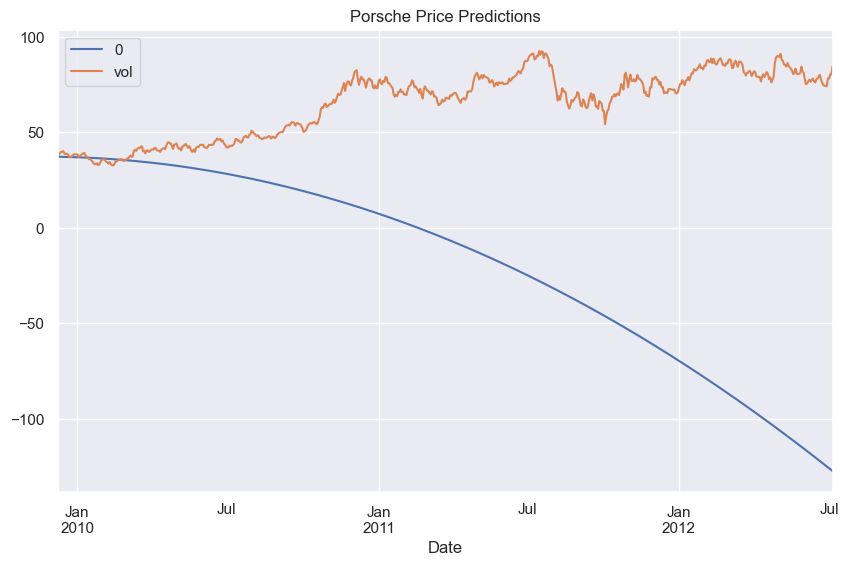

In [27]:
model_auto_pred_pr = auto_arima(df.vol[start_date:announcement_1], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[announcement_1:announcement_2])),
                               index=df[announcement_1:announcement_2].index)

# plot
df_auto_pred_pr[announcement_1:announcement_2].plot(figsize=(10, 6), title='Porsche Price Predictions', legend=True)
df.vol[announcement_1:announcement_2].plot(figsize=(10, 6), title='Porsche Price Predictions', legend=True)
plt.title('Porsche Price Predictions')
plt.xlabel('Date')

* From the above predictions its clear that the model takes time to adjust to the policy changes

## Adding exo variables

Text(0.5, 0, 'Date')

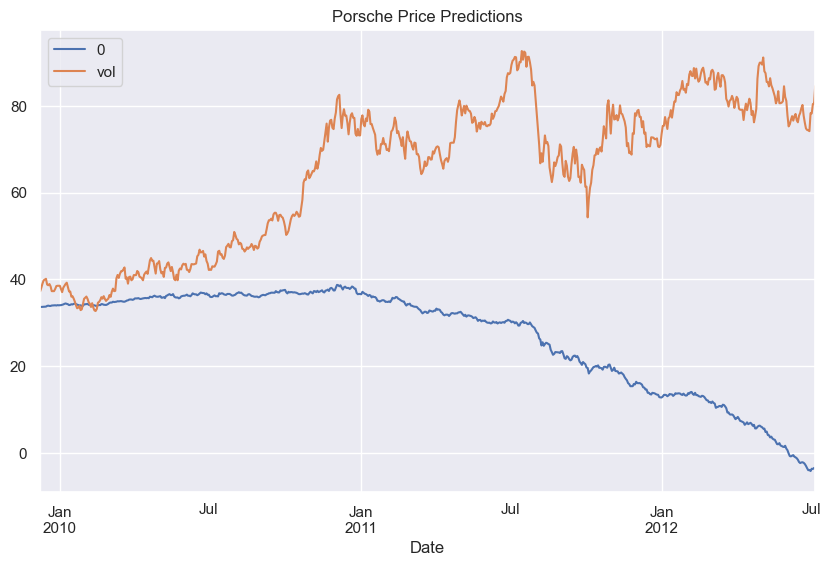

In [30]:
model_auto_pred_pr = auto_arima(df.vol[start_date:announcement_1],X = df[['porsche']][start_date:announcement_1] ,m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[announcement_1:announcement_2]),X = df[['bmw']][announcement_1:announcement_2] ),
                               index=df[announcement_1:announcement_2].index)

# plot
df_auto_pred_pr[announcement_1:announcement_2].plot(figsize=(10, 6), title='Porsche Price Predictions', legend=True)
df.vol[announcement_1:announcement_2].plot(figsize=(10, 6), title='Porsche Price Predictions', legend=True)
plt.title('Porsche Price Predictions')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

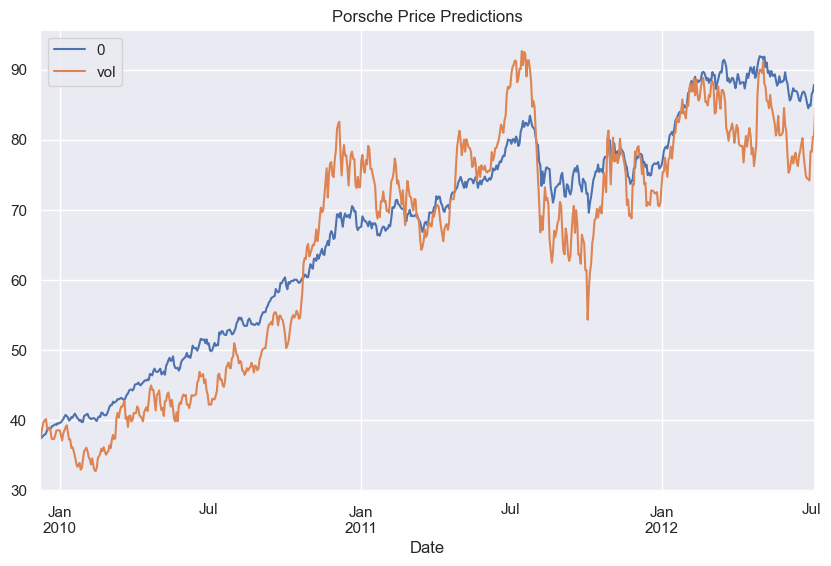

In [31]:
model_auto_pred_pr = auto_arima(df.vol[start_date:announcement_1],X = df[['bmw']][start_date:announcement_1] ,m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[announcement_1:announcement_2]),X = df[['bmw']][announcement_1:announcement_2] ),
                               index=df[announcement_1:announcement_2].index)

# plot
df_auto_pred_pr[announcement_1:announcement_2].plot(figsize=(10, 6), title='Porsche Price Predictions', legend=True)
df.vol[announcement_1:announcement_2].plot(figsize=(10, 6), title='Porsche Price Predictions', legend=True)
plt.title('Porsche Price Predictions')
plt.xlabel('Date')